In [ ]:
import zipfile
import os
import random
import shutil

# Paths
ZIP_PATH = "dogs-vs-cats.zip"
EXTRACT_PATH = "dogs-vs-cats"
TRAIN_ZIP_PATH = os.path.join(EXTRACT_PATH, "train.zip")
BASE_DIR = "data"

# Unzip main zip
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# Unzip train.zip
with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# Create directory structure
for split in ["train", "val", "test"]:
    for cls in ["cats", "dogs"]:
        os.makedirs(os.path.join(BASE_DIR, split, cls), exist_ok=True)

# Collect images
all_images = os.listdir(EXTRACT_PATH)
cats = [img for img in all_images if img.startswith("cat.")]
dogs = [img for img in all_images if img.startswith("dog.")]

def split_and_copy(images, cls_name):
    random.shuffle(images)
    n = len(images)
    train_end = int(0.7 * n)
    val_end = int(0.8 * n)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits.items():
        for f in files:
            shutil.copy(
                os.path.join(EXTRACT_PATH, f),
                os.path.join(BASE_DIR, split, cls_name, f)
            )

split_and_copy(cats, "cats")
split_and_copy(dogs, "dogs")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import shutil
import random

# --- Self-correction: Populate data if directories are empty ---
BASE_DIR = "data"
EXTRACT_PATH = "dogs-vs-cats"
# The kernel state shows images are in dogs-vs-cats/train/
CORRECT_SOURCE = os.path.join(EXTRACT_PATH, "train")

if not os.path.exists(os.path.join(BASE_DIR, "train", "cats")) or not os.listdir(os.path.join(BASE_DIR, "train", "cats")):
    if os.path.exists(CORRECT_SOURCE):
        print(f"Detected empty data folders. Populating from {CORRECT_SOURCE}...")
        all_images = os.listdir(CORRECT_SOURCE)
        cats_list = [img for img in all_images if img.startswith("cat.")]
        dogs_list = [img for img in all_images if img.startswith("dog.")]

        def split_and_copy_fixed(images, cls_name):
            random.shuffle(images)
            n = len(images)
            train_end = int(0.7 * n)
            val_end = int(0.8 * n)
            splits = {
                "train": images[:train_end],
                "val": images[train_end:val_end],
                "test": images[val_end:]
            }
            for split, files in splits.items():
                target_dir = os.path.join(BASE_DIR, split, cls_name)
                os.makedirs(target_dir, exist_ok=True)
                for f in files:
                    shutil.copy(os.path.join(CORRECT_SOURCE, f), os.path.join(target_dir, f))

        split_and_copy_fixed(cats_list, "cats")
        split_and_copy_fixed(dogs_list, "dogs")
        print("Data population complete.")
    else:
        print(f"Warning: Source directory {CORRECT_SOURCE} not found. Please re-run the extraction cell.")

# --- Data augmentation for training ---
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# No augmentation for validation/test
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('data/val', transform=val_transforms)
test_dataset = datasets.ImageFolder('data/test', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Detected empty data folders. Populating from dogs-vs-cats/train...
Data population complete.
Training samples: 17500
Validation samples: 2500
Test samples: 5000


In [ ]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Using device: {device}')
print(f'Training only final layer with {model.fc.in_features} output to 2')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Using device: cuda
Training only final layer with 512 output to 2


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# Training tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Saved best model with val_acc: {val_acc:.2f}%')

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f' Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f' Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()


Saved best model with val_acc: 97.08%
Epoch [1/10]
 Train Loss: 0.1719, Train Acc: 93.08%
 Val Loss: 0.0731, Val Acc: 97.08%

Saved best model with val_acc: 98.04%
Epoch [2/10]
 Train Loss: 0.1245, Train Acc: 94.90%
 Val Loss: 0.0550, Val Acc: 98.04%

Epoch [3/10]
 Train Loss: 0.1173, Train Acc: 95.13%
 Val Loss: 0.0570, Val Acc: 97.76%

Epoch [4/10]
 Train Loss: 0.1115, Train Acc: 95.51%
 Val Loss: 0.0608, Val Acc: 97.72%

Epoch [5/10]
 Train Loss: 0.1067, Train Acc: 95.70%
 Val Loss: 0.0708, Val Acc: 96.76%

Epoch [6/10]
 Train Loss: 0.1156, Train Acc: 95.27%
 Val Loss: 0.0575, Val Acc: 97.76%

Epoch [7/10]
 Train Loss: 0.1034, Train Acc: 95.73%
 Val Loss: 0.0520, Val Acc: 97.96%

Epoch [8/10]
 Train Loss: 0.1040, Train Acc: 95.76%
 Val Loss: 0.0526, Val Acc: 97.92%

Saved best model with val_acc: 98.16%
Epoch [9/10]
 Train Loss: 0.1064, Train Acc: 95.59%
 Val Loss: 0.0489, Val Acc: 98.16%

Epoch [10/10]
 Train Loss: 0.1000, Train Acc: 95.88%
 Val Loss: 0.0537, Val Acc: 97.92%



In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 97.80%


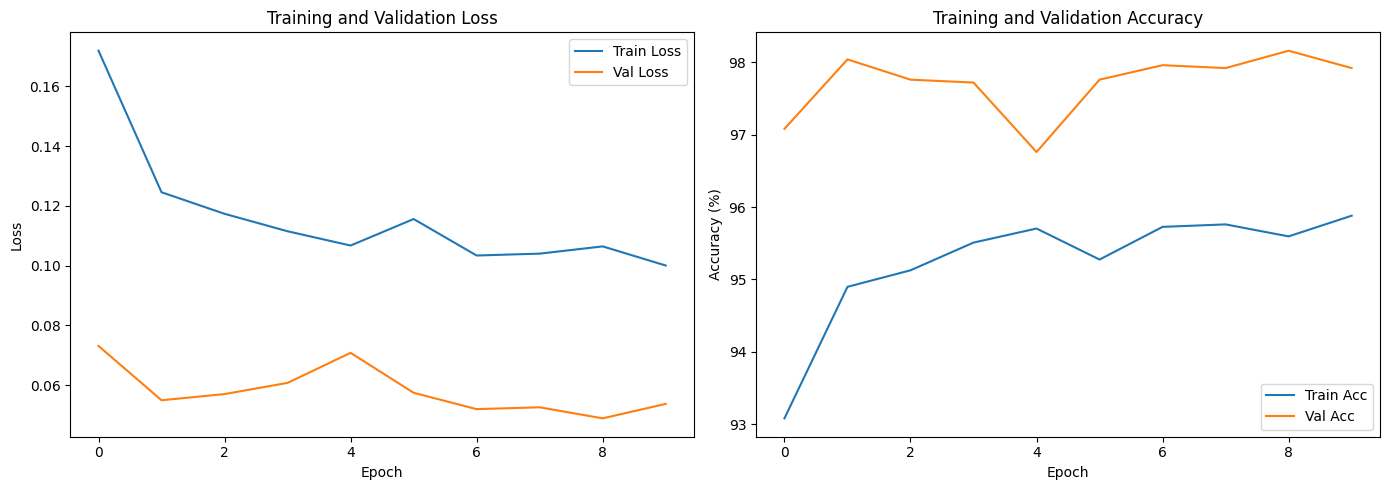

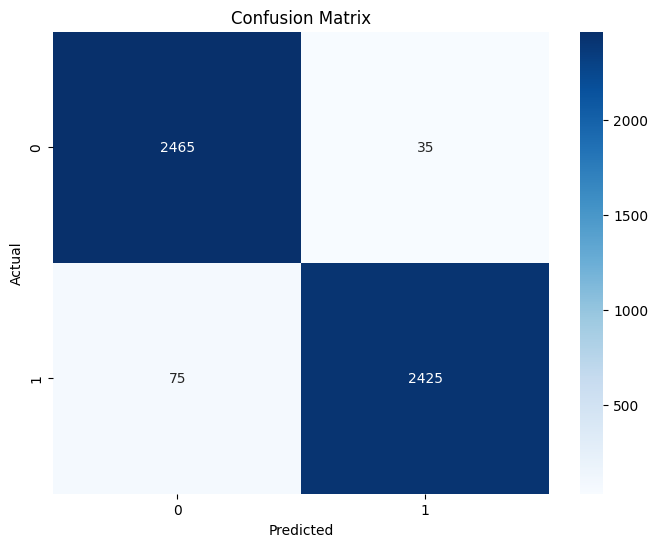

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
